In [69]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(color_codes=True)

# Data Import

In [70]:
raw_data = pd.read_csv('~/Downloads/bq-results-20200613-172659-qyga7irf1y6u.csv')

In [71]:
parsed_data = pd.concat([
        raw_data['project_name'], 
        pd.to_datetime(raw_data['earliest_commit_sec'], unit='s'),
        pd.to_datetime(raw_data['latest_commit_sec'], unit='s'),
        raw_data['number_of_commits']
    ], axis=1
)
parsed_data.set_index(['project_name'], inplace=True)

# get an idea of "now" that accounts for when the dataset was actually updated
now = parsed_data['earliest_commit_sec'].max()

parsed_data = parsed_data.loc[parsed_data.latest_commit_sec < (now - pd.Timedelta(days=90))]
parsed_data['project_age'] = parsed_data.latest_commit_sec - parsed_data.earliest_commit_sec

In [72]:
data = parsed_data.copy()
all_project_ages = data.project_age.dt.days / 365.25
all_project_ages = all_project_ages.loc[all_project_ages > 0]
all_project_ages.name = 'project_age_years'

# Data exploration

In [73]:
project_ages = all_project_ages.copy()

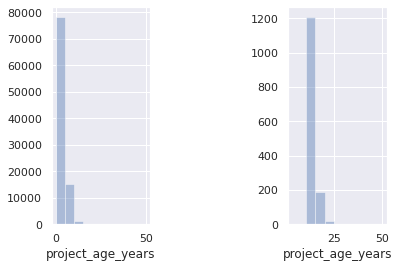

In [93]:
try:
    fig.clear()
    del fig
except NameError:
    pass

fig, ax = plt.subplots()
plt.subplot(1, 3, 1)
sns.distplot(project_ages, kde=False, bins=[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50])
plt.subplot(1, 3, 3)
sns.distplot(project_ages, kde=False, bins=[10, 15, 20, 25, 30, 35, 40, 45, 50])
fig.savefig('project_age_years_hist.svg', bbox_inches='tight')

In [75]:
project_ages = project_ages.loc[project_ages < 20]

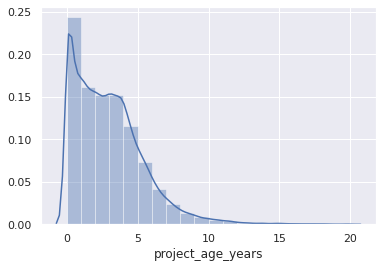

In [76]:
fig, ax = plt.subplots()
sns.distplot(project_ages, ax=ax, bins=range(20))
fig.savefig('project-age-simple-distribution.svg', bbox_inches='tight')

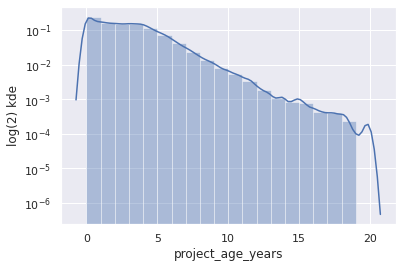

In [77]:
fig, ax = plt.subplots()
sns.distplot(project_ages, ax=ax, bins=range(20))
ax.set_yscale('log')
ax.set_ylabel('log(2) kde')
fig.savefig('project-age-log-distribution.svg')

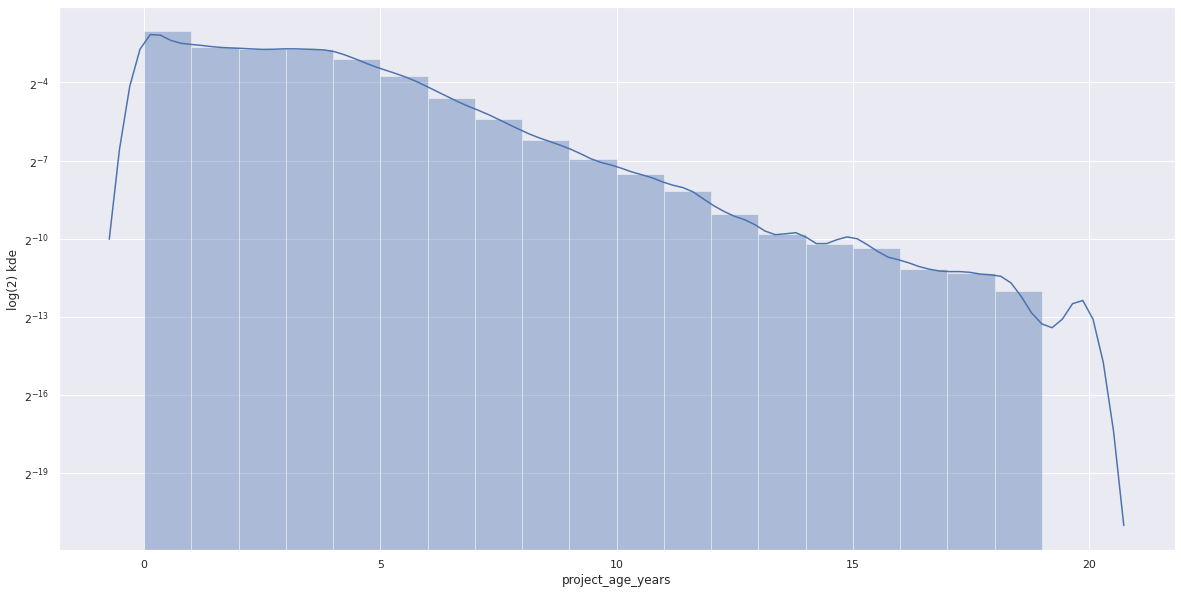

In [78]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.distplot(project_ages, ax=ax, bins=range(20))
ax.set_yscale('log', basey=2)
ax.set_ylabel('log(2) kde')
fig.savefig('project-age-log-distribution-filtered.svg', bbox_inches='tight')

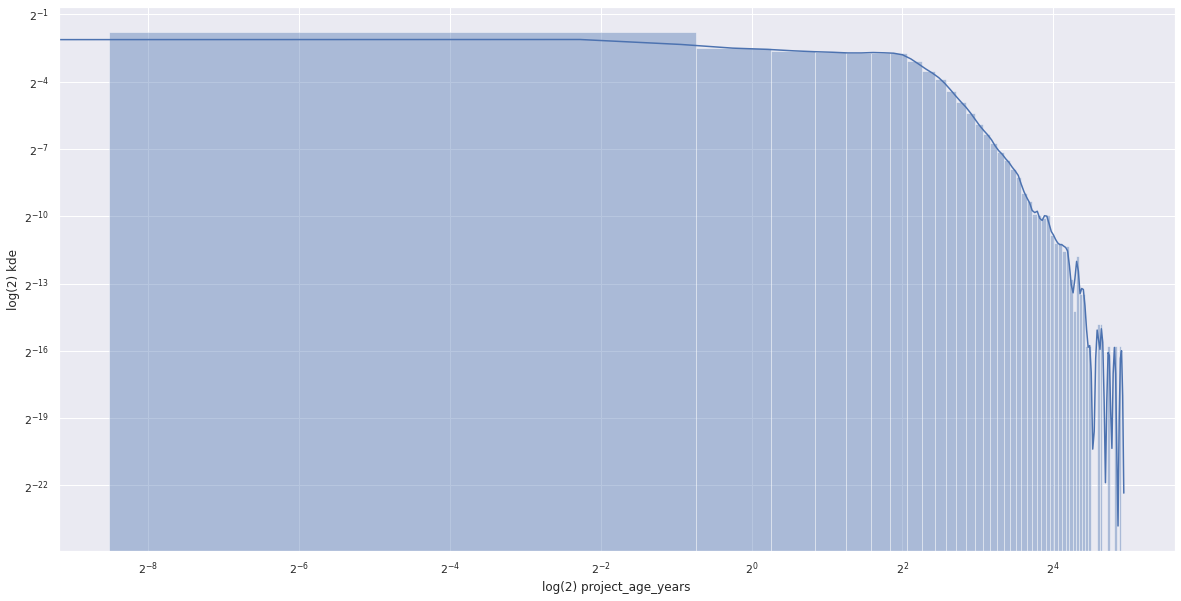

In [95]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.distplot(project_ages, ax=ax)
ax.set_yscale('log', basey=2)
ax.set_ylabel('log(2) kde')
ax.set_xscale('log', basex=2)
ax.set_xlabel('log(2) project_age_years')
fig.savefig('project-age-log-log-distribution-filtered.svg', bbox_inches='tight')

# Analysis

In [104]:
def compute_life_expectancies(data_points, max_age):
    rles = []
    for year in range(0, 2*max_age):
        year = year/2.0
        projects_that_live_long_enough = project_ages.loc[project_ages > year]
        remaining_life_expectancies = projects_that_live_long_enough - year
        rle = pd.DataFrame({'years_past': year, 'remaining_life_years': remaining_life_expectancies})
        rles.append(rle)
        
    return pd.concat(rles)


def plot_expectancies(life_expectancy_data):

    fig, ax = plt.subplots(figsize=(20,10))
    
    rles = life_expectancy_data.groupby(['years_past']).remaining_life_years
    rles = rles.agg([
        'mean',
        lambda x: x.quantile(0.3),
        'median',
        lambda x: x.quantile(0.9),
    ])
    rles.columns = [
        'life expectancy (mean)',
        '30th-percentile',
        '50th-percentile',
        '90th-percentile', 
    ]
    
    rles.plot(ax=ax)
    
    ax.legend(loc='upper right')
    ax.set_ylabel('Estimated remaining life expectancy (years)')
    ax.set_zorder(2)
    ax.patch.set_alpha(0.8)
    ax.set_yticks(range(0, int(life_expectancy_data.years_past.max()) + 2, 2))
    
    sample_count = life_expectancy_data.groupby(['years_past']).count()
    rh_ax = ax.twinx()
    l2 = rh_ax.bar(
        sample_count.index, sample_count.remaining_life_years,
        width=0.3, color='grey',
        label='samples used')
    rh_ax.set_ylabel('log(10) Number of samples used')
    rh_ax.set_yscale('log')
    rh_ax.set_ylim([1, 10_000_000])
    rh_ax.legend(loc='lower right')
    rh_ax.set_zorder(1)
    
    
    return fig


## remaining life expectancies - all data points

In [105]:
try:
    fig.clear()
    del fig
except NameError:
    pass


In [106]:
project_ages = all_project_ages.copy()
rle_data = compute_life_expectancies(project_ages, 30)

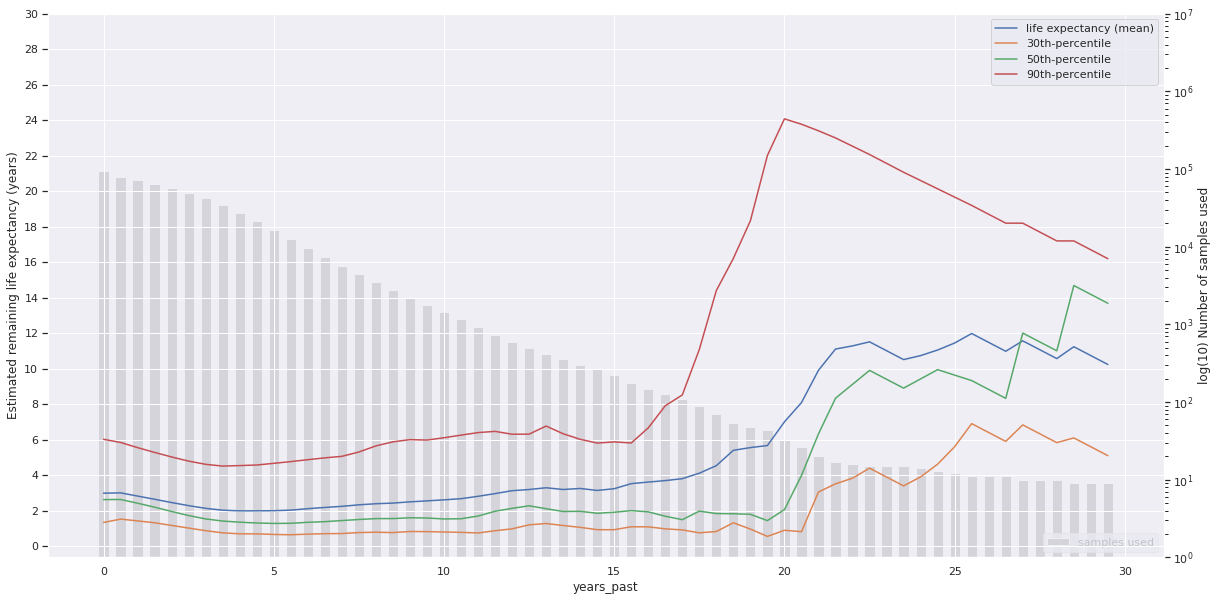

In [107]:
fig = plot_expectancies(rle_data)
fig.savefig('remaining_life_expectancy_all.svg', bbox_inches='tight')

## remaining life expectancies - cut down

In [108]:
try:
    fig.clear()
    del fig
except NameError:
    pass


In [109]:

project_ages = all_project_ages.copy()
project_ages = project_ages.loc[project_ages < 30]

In [110]:
rle_data = compute_life_expectancies(project_ages, 10)


In [111]:
project_ages.quantile(0.4)

1.9685147159479808

In [112]:
rle_data.loc[rle_data.years_past == 0.0].remaining_life_years.quantile(0.1)

0.2190280629705681

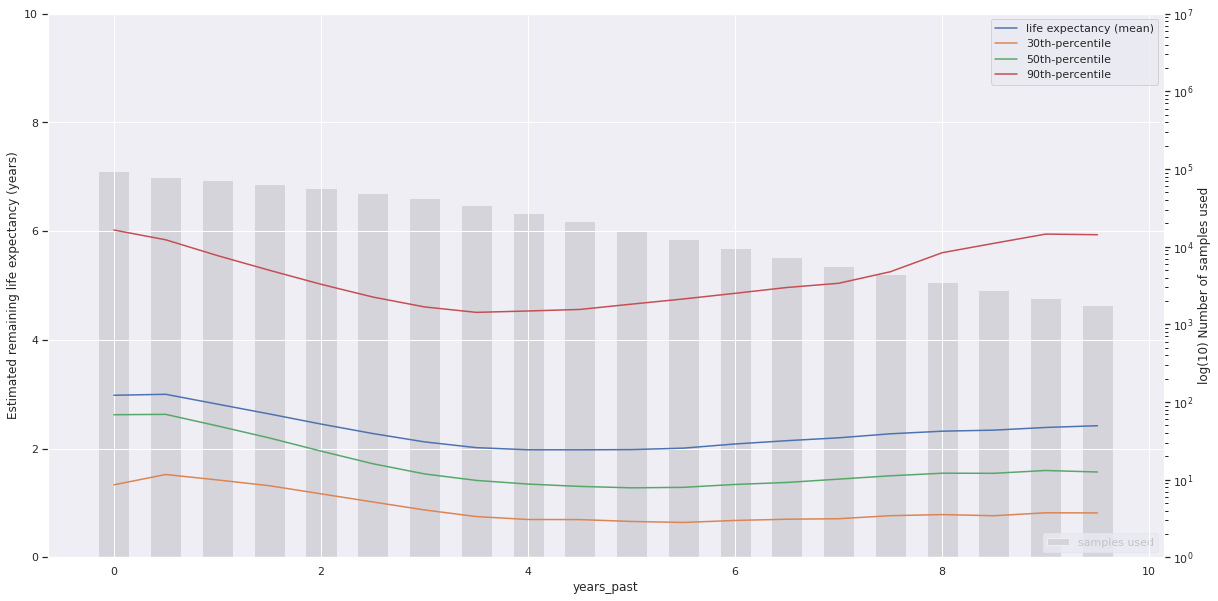

In [113]:
fig = plot_expectancies(rle_data)
fig.savefig('remaining_life_expectancy_sub_10.svg', bbox_inches='tight')